# 1.建立一個有簡單短期記憶的聊天機器人

<img src="https://drive.google.com/uc?export=view&id=1Xe-WwHsVBzO6kt0A9TEbYR871coqF03d" width="100"/>

流程：使用者問題(Start) ⭢ 聊天機器人回應(chatbot) ⭢ 回應送給使用者(End)
- 在chatbot的node中，會將聊天記錄存到State中


名詞解釋：
- thread: 同一個對話串為一個thread

In [ ]:
%%capture --no-stderr
!pip install -U langgraph langchain transformers bitsandbytes langchain-huggingface langchain_openai==0.3.15

### load local 模型

In [ ]:
%%capture --no-stderr
# 使用local模型，會需要一點時間
# 使用local模型，記得將runtime調到T4 GPU (runtime -> change runtime type)
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

In [ ]:
# 建立 text generation pipeline
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

# 包裝成 LangChain 的 llm 物件
llm_local = HuggingFacePipeline(pipeline=generator)

Device set to use cuda:0


### 使用api (huggingface or openai)

In [ ]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

# 課金openai
llm_api = ChatOpenAI(model="gpt-4o-mini")  # 你可以換成 "gpt-4" 或其他 OpenAI 模型名稱

# 呼叫huggingface上的API模型 (free)
llm_endpoint = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-32B-Instruct",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)

llm_huggingface = ChatHuggingFace(llm=llm_endpoint, verbose=False)

### 建立一個有狀態的圖(StateGraph)


In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import convert_to_openai_messages, SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_core.runnables.config import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
  """
  若只有messages, 其實等同於MessageState
  這邊保留彈性
  """
  messages: Annotated[list, add_messages]

def chatbot(state: State, config: RunnableConfig):
  """
  主要處理chatbot回應的邏輯
  這裡僅單純將使用者的對話紀錄(傳入的state中的messages)，送入模型產生回應
  """

  system_prompt = "你是個只能使用繁體中文回答的助理"
  mode = config["configurable"]["mode"] # 決定要使用哪個模型

  if mode == "local":
    messages = convert_to_openai_messages(state["messages"]) # Convert LangChain messages into OpenAI message dicts.
    system_message =  [{"role": "system", "content": system_prompt}]
    # apply tokenizer prompt template
    prompt = tokenizer.apply_chat_template(
        system_message+messages,
        tokenize=False,
        add_generation_prompt=True
    )
    response = llm_local.invoke(prompt)
    return {"messages": [AIMessage(content=response)]}
  else:
    system_message = [SystemMessage(content=system_prompt)]
    messages = state["messages"]
    if mode == "openai_api":
      response = llm_api.invoke(system_message+messages)
    elif mode == "huggingface":
      response = llm_huggingface.invoke(system_message+messages)
    return {"messages": [response]}


# 建立一個有StateGraph
graph_builder = StateGraph(State)
#                     node name, 呼叫node時要觸發的邏輯(function or object)
graph_builder.add_node("chatbot", chatbot) # 在graph裡面加入chatbot的node
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 加入記憶性
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

### Messages補充：

langchain/langgraph messages:
```
[SystemMessage(content="你是個只能使用繁體中文回答的助理"),
 HumanMessage(content='hi'),
 AIMessage(content='你好，我可以幫上什麼忙嗎'),
 HumanMessage(content='hihi')]
```

Hugging Face
```
[{"role": "system", "content": "你是個只能使用繁體中文回答的助理"},
{"role": "user", "content": "hi"},
{"role": "assistant", "content": "你好，我可以幫上什麼忙嗎"},
{"role": "user", "content": "你好"},]

```

Mediatek prompt: (tokenizer.chat_template)
```
<s> 你是個只能使用繁體中文回答的助理。  [INST] hi [/INST] 你好！如果你有任何問題或需要幫助，請不要猶豫，隨時告訴我。 [INST] 你好 [/INST]

```

其他模型prompt template：

```
"""<|im_start|>user
Hi there!<|im_end|>
<|im_start|>assistant
Nice to meet you!<|im_end|>
<|im_start|>user
Can I ask a question?<|im_end|>
"""
```

In [ ]:
tokenizer.chat_template

"{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% if messages[0]['role'] == 'system' %}{% set loop_messages = messages[1:] %}{% set system_message = messages[0]['content'].strip() %}{% else %}{% set loop_messages = messages %}{% set system_message = 'You are a helpful AI assistant built by MediaTek Research. The user you are helping speaks Traditional Chinese and comes from Taiwan.' %}{% endif %}{{ bos_token }} {{ system_message }} {% for message in loop_messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/... or system/user/assistant/user/assistant/...') }}{% endif %}{% if message['role'] == 'user' %}{{ ' [INST] ' + message['content'] + ' [/INST] ' }}{% elif message['role'] == 'assistant' %}{{ message['content'] }}{% else %}{{ raise_exception('Only user and assistant roles are supported!') }}{% endif %}{% endfor %}"

In [ ]:
out = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": "A system prompt"},
        {"role": "user", "content": "Hi there!"},
        {"role": "assistant", "content": "Nice to meet you!"},
        {"role": "user", "content": "Can I ask a question?"}
    ],
    tokenize=False,
    add_generation_prompt=True
)
print(out)

<s> A system prompt  [INST] Hi there! [/INST] Nice to meet you! [INST] Can I ask a question? [/INST] 


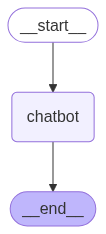

In [5]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [8]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [9]:
# 第一次對話 (thread_id: conversation_1)
mode = "openai_api"
config_1 = {"configurable": {"thread_id": "conversation_1", "mode": mode}} # thread_id: 對話id

while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config_1)
  except Exception as e:
    print(e)
    break

User: 嗨 我是火影忍者迷
Assistant: 嗨！很高興遇到火影忍者的粉絲！你最喜歡的角色是誰？或是有沒有特別喜歡的劇情呢？
User: 我喜歡宇智波佐助
Assistant: 宇智波佐助是一個非常有魅力的角色！他的背景故事和成長過程都相當曲折，而且他的能力也非常強大。你最喜歡佐助的哪個部分呢？是他的戰鬥風格，還是他與其他角色之間的關係？
User: 我們來聊點別的
Assistant: 當然可以！你想聊什麼呢？有任何特別的興趣或話題想討論的嗎？
User: 那你還記得我喜歡甚麼嗎
Assistant: 當然，妳喜歡宇智波佐助！如果想聊佐助以外的話題或任何其他興趣，隨時告訴我！你還有其他喜歡的動漫或角色嗎？
User: q
Goodbye!


In [10]:
# 看state
graph.get_state(config_1)

StateSnapshot(values={'messages': [HumanMessage(content='嗨 我是火影忍者迷', additional_kwargs={}, response_metadata={}, id='9df03173-02ff-45c0-8f1a-4c1009b4986d'), AIMessage(content='嗨！很高興遇到火影忍者的粉絲！你最喜歡的角色是誰？或是有沒有特別喜歡的劇情呢？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 32, 'total_tokens': 70, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-BZaJDiS5bSBhnewyx05d6WINSMDBc', 'finish_reason': 'stop', 'logprobs': None}, id='run--003f50cf-907e-4676-866a-099a1234a575-0', usage_metadata={'input_tokens': 32, 'output_tokens': 38, 'total_tokens': 70, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='我喜歡宇智波佐助

In [11]:
# 易讀版
def state_pretty_print(state: State):
  for m in state.values["messages"]:
    m.pretty_print()

In [12]:
state_pretty_print(graph.get_state(config_1))

================================ Human Message =================================

嗨 我是火影忍者迷
================================== Ai Message ==================================

嗨！很高興遇到火影忍者的粉絲！你最喜歡的角色是誰？或是有沒有特別喜歡的劇情呢？
================================ Human Message =================================

我喜歡宇智波佐助
================================== Ai Message ==================================

宇智波佐助是一個非常有魅力的角色！他的背景故事和成長過程都相當曲折，而且他的能力也非常強大。你最喜歡佐助的哪個部分呢？是他的戰鬥風格，還是他與其他角色之間的關係？
================================ Human Message =================================

我們來聊點別的
================================== Ai Message ==================================

當然可以！你想聊什麼呢？有任何特別的興趣或話題想討論的嗎？
================================ Human Message =================================

那你還記得我喜歡甚麼嗎
================================== Ai Message ==================================

當然，妳喜歡宇智波佐助！如果想聊佐助以外的話題或任何其他興趣，隨時告訴我！你還有其他喜歡的動漫或角色嗎？


In [13]:
## 第二次對話
mode = "openai_api"
config_2 = {"configurable": {"thread_id": "conversation_2", "mode": mode}} # thread_id: 對話id

while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config_2)
  except Exception as e:
    print(e)
    break

User: 你還記得我喜歡甚麼嗎
Assistant: 抱歉，我無法記住過去的對話或個人信息。如果你能告訴我你喜歡什麼，我會很樂意幫助你！
User: q
Goodbye!


In [14]:
state_pretty_print(graph.get_state(config_2))

================================ Human Message =================================

你還記得我喜歡甚麼嗎
================================== Ai Message ==================================

抱歉，我無法記住過去的對話或個人信息。如果你能告訴我你喜歡什麼，我會很樂意幫助你！


# 2.Langgraph中的InMemoryStore介紹

組成：
- namespace：物件的命名空間，類似於目錄（資料夾），是一個元組（tuple）
- key：物件的鍵，類似於檔案名稱
- value：物件的值，類似於檔案內容

方法：
- put: 將欲放入的key-value放到指定的namespace
- search: 找尋指定的namespace
- get: 從指定的namespace, 找到指定key中的值

In [15]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

In [16]:
## 寫入長期記憶

# Save the memory   #
in_memory_store.put(namespace=("user_1", "memories"), key="profile", value={"name": "Amy", "gender": "f", "age": 22})
in_memory_store.put(namespace=("user_1", "memories"), key="interests", value=["kendo", "hiking", "reading"])
in_memory_store.put(namespace=("user_2", "memories"), key="profile", value={"name": "Boris", "gender": "m", "age":30 })
in_memory_store.put(namespace=("user_2", "memories"), key="interests", value=["coding", "sleeping"])


In [17]:
# search
# 從namesapce抓取長期記憶
memories = in_memory_store.search(("user_1", "memories"))
print("type of memories: ",type(memories))
print(memories)

type of memories:  <class 'list'>
[Item(namespace=['user_1', 'memories'], key='profile', value={'name': 'Amy', 'gender': 'f', 'age': 22}, created_at='2025-05-21T09:49:49.610738+00:00', updated_at='2025-05-21T09:49:49.610743+00:00', score=None), Item(namespace=['user_1', 'memories'], key='interests', value=['kendo', 'hiking', 'reading'], created_at='2025-05-21T09:49:49.610842+00:00', updated_at='2025-05-21T09:49:49.610843+00:00', score=None)]


In [18]:
memories = in_memory_store.search(("user_2", "memories"))
print(memories)

[Item(namespace=['user_2', 'memories'], key='profile', value={'name': 'Boris', 'gender': 'm', 'age': 30}, created_at='2025-05-21T09:49:49.610915+00:00', updated_at='2025-05-21T09:49:49.610916+00:00', score=None), Item(namespace=['user_2', 'memories'], key='interests', value=['coding', 'sleeping'], created_at='2025-05-21T09:49:49.610977+00:00', updated_at='2025-05-21T09:49:49.610978+00:00', score=None)]


In [19]:
# get
# 從namesapce + key抓取特定長期記憶
memory = in_memory_store.get(("user_1", "memories"), "profile")
memory.value

{'name': 'Amy', 'gender': 'f', 'age': 22}

In [20]:
memory = in_memory_store.get(("user_1", "memories"), "interests")
memory.value

['kendo', 'hiking', 'reading']